# Election Tweet Sentiment Analysis

## Project Goal
Analyze Twitter sentiment around the 2020 U.S. Presidential Election to explore:
- How sentiment changed over time
- Differences between candidates
- Whether sentiment patterns help explain or predict state-level outcomes

## Why this matters
Social media sentiment is often cited as a proxy for public opinion. This project evaluates whether that assumption holds when tested against real election results.

## Key Questions
1. Does tweet sentiment differ significantly between candidates?
2. How does sentiment evolve before and after Election Day?
3. Are swing states sentimentally distinct from non-swing states?
4. Can aggregated sentiment features help predict close states?

# Load and clean data

In [2]:
# import packages
import pandas as pd
import numpy as np
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
"""
Read in files from Google Drive
1. df_trump: tweets involving Donald Trump
2. df_biden: tweets involving Joe Biden
"""
df_trump = pd.read_csv(
    '/content/drive/MyDrive/Colab Notebooks/hashtag_donaldtrump.csv',
    encoding='latin1',
    engine='python',
    on_bad_lines='skip'
)

df_biden = pd.read_csv(
    '/content/drive/MyDrive/Colab Notebooks/hashtag_joebiden.csv',
    encoding='latin1',
    engine='python',
    on_bad_lines='skip'
)


In [20]:
election_results = pd.read_csv("2020_election_results.csv")

In [4]:
df_trump.head()

,created_at,tweet_id,tweet,likes,retweet_count,source,user_id,user_name,user_screen_name,user_description,...,user_followers_count,user_location,lat,long,city,country,continent,state,state_code,collected_at
0,2020-10-15 00:00:01,1.316529221557252e+18,#Elecciones2020 | En #Florida: #JoeBiden dice ...,0.0,0.0,TweetDeck,360666534.0,El Sol Latino News,elsollatinonews,ð Noticias de interÃ©s para latinos de la c...,...,1860.0,"Philadelphia, PA / Miami, FL",25.77427,-80.19366,NaN,United States of America,North America,Florida,FL,2020-10-21 00:00:00
1,2020-10-15 00:00:01,1.3165292227484303e+18,"Usa 2020, Trump contro Facebook e Twitter: cop...",26.0,9.0,Social Mediaset,331617619.0,Tgcom24,MediasetTgcom24,Profilo ufficiale di Tgcom24: tutte le notizie...,...,1067661.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 00:00:00.373216530
2,2020-10-15 00:00:02,1.316529228091847e+18,"#Trump: As a student I used to hear for years,...",2.0,1.0,Twitter Web App,8436472.0,snarke,snarke,"Will mock for food! Freelance writer, blogger,...",...,1185.0,Portland,45.5202471,-122.6741949,Portland,United States of America,North America,Oregon,OR,2020-10-21 00:00:00.746433060
3,2020-10-15 00:00:02,1.316529227471237e+18,2 hours since last tweet from #Trump! Maybe he...,0.0,0.0,Trumpytweeter,8.28355589206057e+17,Trumpytweeter,trumpytweeter,"If he doesn't tweet for some time, should we b...",...,32.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 00:00:01.119649591
4,2020-10-15 00:00:08,1.3165292523014513e+18,You get a tie! And you get a tie! #Trump âs ...,4.0,3.0,Twitter for iPhone,47413798.0,Rana Abtar - Ø±ÙØ§ Ø£Ø¨ØªØ±,Ranaabtar,"Washington Correspondent, Lebanese-American ,c...",...,5393.0,Washington DC,38.8949924,-77.0365581,Washington,United States of America,North America,District of Columbia,DC,2020-10-21 00:00:01.492866121


In [5]:
df_biden.head()

,created_at,tweet_id,tweet,likes,retweet_count,source,user_id,user_name,user_screen_name,user_description,...,user_followers_count,user_location,lat,long,city,country,continent,state,state_code,collected_at
0,2020-10-15 00:00:01,1.316529221557252e+18,#Elecciones2020 | En #Florida: #JoeBiden dice ...,0.0,0.0,TweetDeck,360666534.0,El Sol Latino News,elsollatinonews,ð Noticias de interÃ©s para latinos de la c...,...,1860.0,"Philadelphia, PA / Miami, FL",25.77427,-80.19366,NaN,United States of America,North America,Florida,FL,2020-10-21 00:00:00
1,2020-10-15 00:00:18,1.31652929585929e+18,#HunterBiden #HunterBidenEmails #JoeBiden #Joe...,0.0,0.0,Twitter for iPad,809904438.0,Cheri A. ðºð¸,Biloximeemaw,"Locked and loaded Meemaw. Love God, my family ...",...,6628.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 00:00:00.517827283
2,2020-10-15 00:00:20,1.3165293050069524e+18,@IslandGirlPRV @BradBeauregardJ @MeidasTouch T...,0.0,0.0,Twitter Web App,3494182277.0,Flag Waver,Flag_Wavers,NaN,...,1536.0,Golden Valley Arizona,46.3040364,-109.17143119999999,NaN,United States of America,North America,Montana,MT,2020-10-21 00:00:01.035654566
3,2020-10-15 00:00:21,1.3165293080815575e+18,@chrislongview Watching and setting dvr. Letâ...,0.0,0.0,Twitter for iPhone,8.242596012018524e+17,Michelle Ferg,MichelleFerg4,NaN,...,27.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 00:00:01.553481849
4,2020-10-15 00:00:22,1.316529312741253e+18,#censorship #HunterBiden #Biden #BidenEmails #...,1.0,0.0,Twitter Web App,1.032806955356545e+18,the Gold State,theegoldstate,A Silicon Valley #independent #News #Media #St...,...,390.0,"California, USA",36.7014631,-118.75599740000001,NaN,United States of America,North America,California,CA,2020-10-21 00:00:02.071309132


In [6]:
# Clean data
df_trump = df_trump[['created_at', 'tweet', 'country', 'state']]
df_biden = df_biden[['created_at', 'tweet', 'country', 'state']]
df_trump['created_at'] = pd.to_datetime(df_trump['created_at'], errors = 'coerce')
df_biden['created_at'] = pd.to_datetime(df_biden['created_at'], errors = 'coerce')

In [7]:
print("Trump df NA: \n", df_trump.isna().sum())
print("Biden df NA: \n", df_biden.isna().sum())

Trump df NA: 
 created_at       168
tweet             14
country       528355
state         650473
dtype: int64
Biden df NA: 
 created_at       187
tweet             78
country       423303
state         516882
dtype: int64


In [8]:
df_trump.dropna(subset=['created_at', 'tweet'], inplace=True)
df_biden.dropna(subset=['created_at', 'tweet'], inplace=True)

# EDA

In [9]:
# Compute sentiment using TextBlob (polarity: -1 to 1, -1 indicates a negative tweet and 1 indicates a positive tweet)
df_trump['sentiment'] = df_trump['tweet'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
df_biden['sentiment'] = df_biden['tweet'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)

In [10]:
# Find average tweet sentiment per day for each candidate
daily_trump = (
    df_trump
    .groupby(pd.Grouper(key='created_at', freq='D'))
    .agg(
        tweet_count=('tweet', 'count'),
        avg_sentiment=('sentiment', 'mean')
    )
    .reset_index()
)

daily_biden = (
    df_biden
    .groupby(pd.Grouper(key='created_at', freq='D'))
    .agg(
        tweet_count=('tweet', 'count'),
        avg_sentiment=('sentiment', 'mean')
    )
    .reset_index()
)


In [11]:
# 5. Candidate level analysis: calculates score based on average sentiment, tweet count
import pandas as pd

def analyze_nominee(name, df):
    return pd.DataFrame({
        'candidate': [name],
        'tweet_count': [len(df)],
        'avg_sentiment': [df['sentiment'].mean()]
    })

# Apply to all nominees
trump_results = analyze_nominee("Trump", df_trump)
trump_results['score'] = trump_results['avg_sentiment'] * np.log1p(trump_results['tweet_count'])
trump_results = trump_results.sort_values('score', ascending=False)
print(trump_results)

biden_results = analyze_nominee("Biden", df_biden)
biden_results['score'] = biden_results['avg_sentiment'] * np.log1p(biden_results['tweet_count'])
biden_results = biden_results.sort_values('score', ascending=False)
print(biden_results)



  candidate  tweet_count  avg_sentiment     score
0     Trump       970919       0.043947  0.605852
  candidate  tweet_count  avg_sentiment     score
0     Biden       776886       0.071496  0.969701


Biden has a higher score than Trump which is reflective of the outcome of the election. While he has less tweets about him, his sentiment was much higher which had a larger impact on his score

In [12]:
election_day = pd.Timestamp("2020-11-07")
election_announcement = pd.Timestamp("2020-11-03")

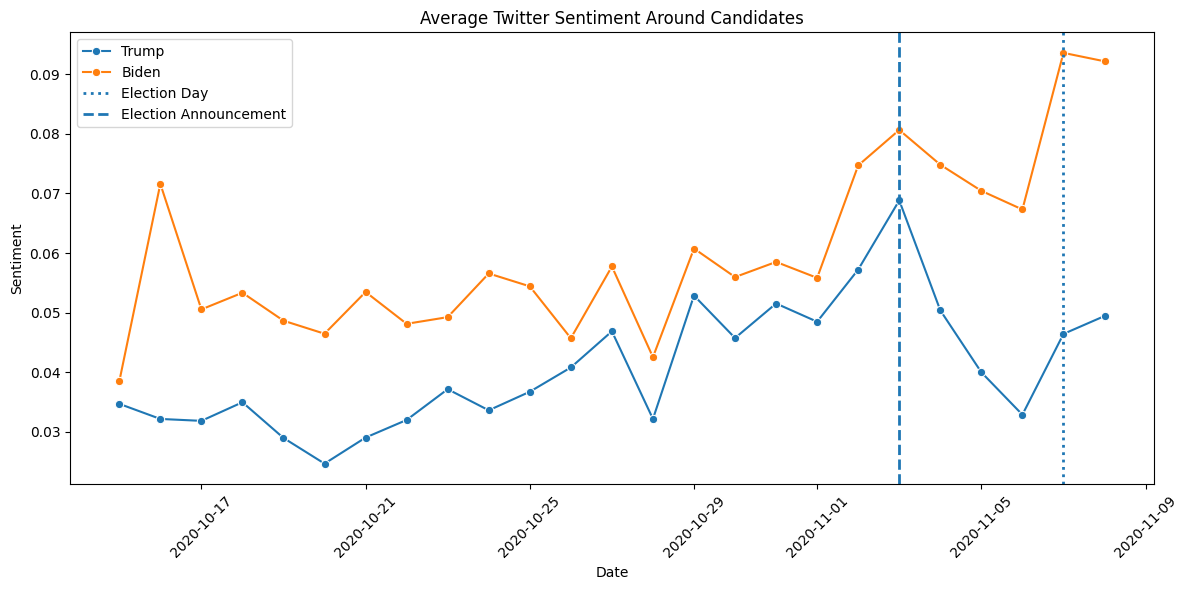

In [13]:
# Visualization: Daily average sentiment
plt.figure(figsize=(12,6))
sns.lineplot(data=daily_trump, x='created_at', y='avg_sentiment', marker='o', label='Trump')
sns.lineplot(data=daily_biden, x='created_at', y='avg_sentiment', marker='o', label = 'Biden')
plt.axvline(election_day, linestyle=':', linewidth=2, label='Election Day')
plt.axvline(election_announcement, linestyle='--', linewidth=2, label='Election Announcement')
plt.title("Average Twitter Sentiment Around Candidates")
plt.xlabel("Date")
plt.ylabel("Sentiment")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

##Observations:
Trump’s average tweet sentiment is consistently lower than Biden’s across the observed time period.

Both candidates exhibit noticeable positive sentiment spikes on Election Day. This suggests a broad increase in emotional engagement on Twitter rather than excitement directed toward a single candidate. Despite this overall rise, Biden maintains a higher average sentiment on Election Day.

A second sentiment increase is observed on the day Biden was announced the winner. This likely reflects heightened Twitter activity from both supporters and critics of each candidate reacting to the election outcome, rather than uniformly positive sentiment toward one side.

In [14]:
# US Sentiment for Trump and Biden
us_trump = df_trump[(df_trump['country'] == 'United States of America') | (df_trump['country'] == 'United States')]
us_biden = df_biden[(df_biden['country'] == 'United States of America') | (df_biden['country'] == 'United States')]

daily_trump_us = us_trump.groupby(pd.Grouper(key='created_at', freq='D')).agg(
    tweet_count=('tweet', 'count'),
    avg_sentiment=('sentiment', 'mean')
).reset_index()
daily_biden_us = us_biden.groupby(pd.Grouper(key='created_at', freq='D')).agg(
    tweet_count=('tweet', 'count'),
    avg_sentiment=('sentiment', 'mean')
).reset_index()


In [15]:
# Outer sentiment before and after elect
non_us_trump = df_trump[~((df_trump['country'] == 'United States of America') | (df_trump['country'] == 'United States'))]
non_us_biden = df_biden[~((df_biden['country'] == 'United States of America') | (df_biden['country'] == 'United States'))]
daily_trump_non_us = non_us_trump.groupby(pd.Grouper(key='created_at', freq='D')).agg(
    tweet_count=('tweet', 'count'),
    avg_sentiment=('sentiment', 'mean')
).reset_index()
daily_biden_non_us = non_us_biden.groupby(pd.Grouper(key='created_at', freq='D')).agg(
    tweet_count=('tweet', 'count'),
    avg_sentiment=('sentiment', 'mean')
).reset_index()


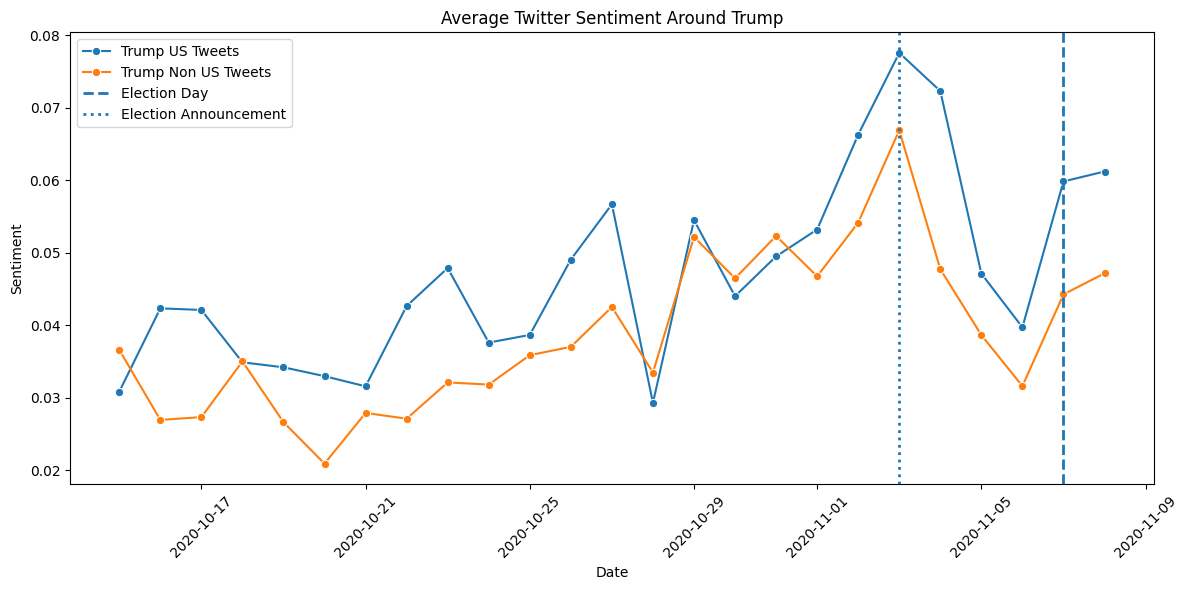

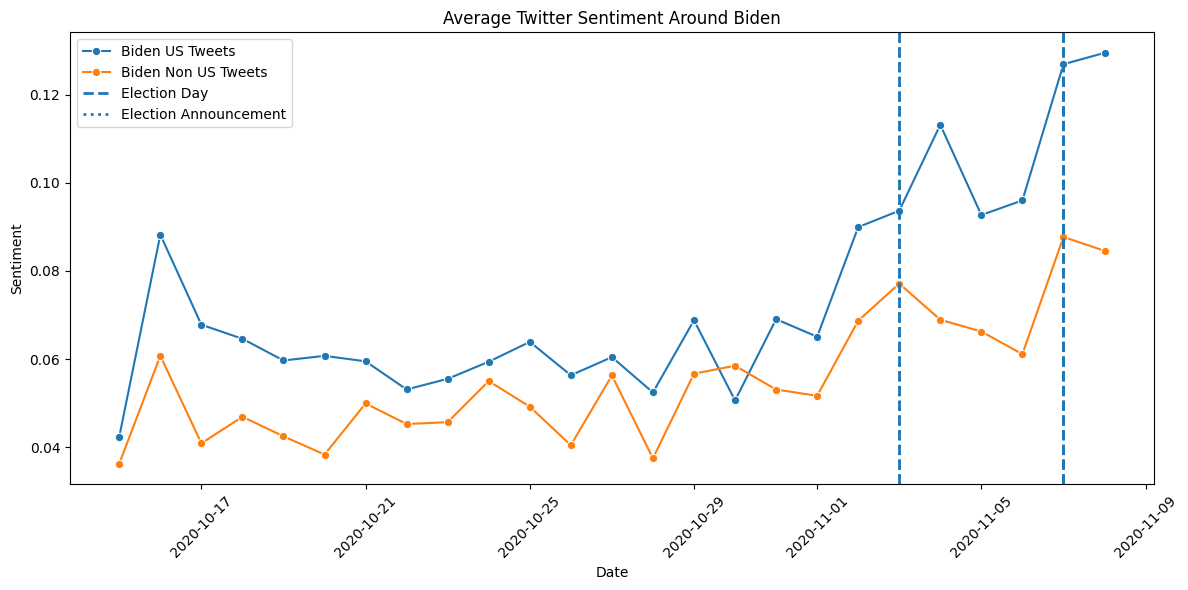

In [16]:
# Visualization: Daily average sentiment for US/Non US based tweets

plt.figure(figsize=(12,6))
sns.lineplot(data=daily_trump_us, x='created_at', y='avg_sentiment', marker='o', label='Trump US Tweets')
sns.lineplot(data=daily_trump_non_us, x='created_at', y='avg_sentiment', marker='o', label='Trump Non US Tweets')
plt.axvline(election_day, linestyle='--', linewidth=2, label='Election Day')
plt.axvline(election_announcement, linestyle=':', linewidth=2, label='Election Announcement')
plt.title("Average Twitter Sentiment Around Trump")
plt.xlabel("Date")
plt.ylabel("Sentiment")
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()
plt.show()

plt.figure(figsize=(12,6))
sns.lineplot(data=daily_biden_us, x='created_at', y='avg_sentiment', marker='o', label='Biden US Tweets')
sns.lineplot(data=daily_biden_non_us, x='created_at', y='avg_sentiment', marker='o', label='Biden Non US Tweets')
plt.axvline(election_day, linestyle='--', linewidth=2, label='Election Day')
plt.axvline(election_announcement, linestyle=':', linewidth=2, label='Election Announcement')
plt.axvline(election_day, linestyle='--', linewidth=2)
plt.axvline(election_announcement, linestyle='--', linewidth=2)
plt.title("Average Twitter Sentiment Around Biden")
plt.xlabel("Date")
plt.ylabel("Sentiment")
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()
plt.show()

Both Trump and Biden follow similar sentiment trends (starting off low and spiking around election time). Also, interestingly, Non US tweet sentiments are consistently lower than US sentiment.

# Modeling

### Clustering

In [17]:
"""
aggregate Trump and Biden tweets by state. Finds:
1. average sentiment (by state)
2. standard deviation in sentiment
3. volume of tweets
4. average positive tweets
"""
trump_state = (
    us_trump
    .dropna(subset=['state'])
    .groupby('state')
    .agg(
        trump_avg_sent=('sentiment', 'mean'),
        trump_std=('sentiment', 'std'),
        trump_volume=('sentiment', 'count'),
        trump_pos_rate=('sentiment', lambda x: (x > 0).mean())
    )
)

biden_state = (
    us_biden
    .dropna(subset=['state'])
    .groupby('state')
    .agg(
        biden_avg_sent=('sentiment', 'mean'),
        biden_std=('sentiment', 'std'),
        biden_volume=('sentiment', 'count'),
        biden_pos_rate=('sentiment', lambda x: (x > 0).mean())
    )
)


In [41]:
# merge state features into one df
state_features = (
    trump_state
    .merge(biden_state, on='state', how='inner')
    .reset_index()
)

state_features.head()


,state,trump_avg_sent,trump_std,trump_volume,trump_pos_rate,biden_avg_sent,biden_std,biden_volume,biden_pos_rate
0,Alabama,0.077916,0.291350,849,0.412250,0.088720,0.283385,864,0.377315
1,Alaska,0.067684,0.265189,311,0.466238,0.065721,0.271075,429,0.365967
2,Arizona,0.054530,0.285103,2865,0.393717,0.082337,0.281600,3248,0.386700
3,Arkansas,0.041041,0.236937,613,0.326264,0.113319,0.281599,469,0.447761
4,California,0.042604,0.277745,31148,0.349107,0.094671,0.282983,25816,0.396498


In [42]:
state_features['sentiment_gap'] = (
    state_features['trump_avg_sent'] - state_features['biden_avg_sent']
)

state_features['volume_ratio'] = (
    state_features['trump_volume'] /
    (state_features['biden_volume'] + 1)
)


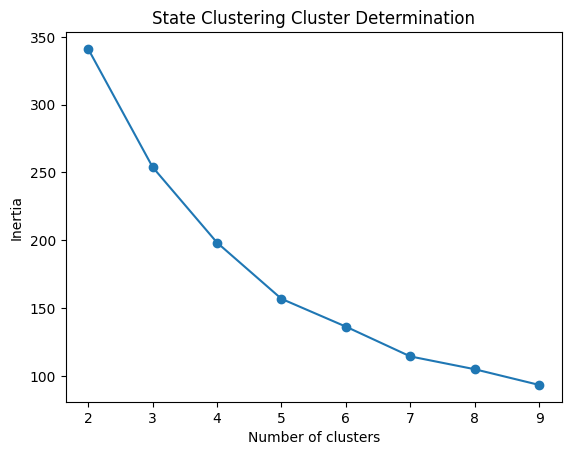

In [43]:
# visualizes the best number of clusters based on inertia
features = state_features.drop(columns=['state'])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

inertias = []

K = range(2, 10)
for k in K:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_scaled)
    inertias.append(km.inertia_)

plt.figure()
plt.plot(K, inertias, marker='o')
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.title("State Clustering Cluster Determination")
plt.show()


This shows that 4 clusters is a good number of clusters based on the elbow method. Inertia measures the sum of squared distances between each point and the center of its assigned cluster. Lower inertia indicates more compact clusters. At 4 clusters (the elbow) clusters are tight enough to be meaningful but not too tight that they are too specific.

In [44]:
# standardizes and scales the data, runs k means clustering on the data
scaler = StandardScaler()

kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
state_features['cluster'] = kmeans.fit_predict(X_scaled)


In [26]:
election_results.rename(columns={'STATE': 'state'}, inplace=True)

In [45]:
state_features = pd.merge(state_features, election_results, on='state', how='left')
state_features.dropna(subset=['Result'], inplace=True)

In [33]:
# gives the cluster definitions for each candidate
cluster_summary = (
    state_features
    .groupby('cluster')
    .mean(numeric_only=True)
)

cluster_summary


,trump_avg_sent,trump_std,trump_volume,trump_pos_rate,biden_avg_sent,biden_std,biden_volume,biden_pos_rate,sentiment_gap,volume_ratio
cluster,,,,,,,,,,
0,0.048624,0.28384,776.400000,0.363386,0.066075,0.272094,673.10,0.339033,-0.017451,1.228966
1,0.050258,0.27733,2724.107143,0.368704,0.091131,0.280225,2350.75,0.394718,-0.040873,1.116242
2,-0.250000,0.50000,4.000000,0.000000,0.100000,0.223607,5.00,0.200000,-0.350000,0.666667
3,0.049522,0.27647,21769.500000,0.351837,0.085340,0.280392,18572.50,0.384552,-0.035818,1.176169




*   Cluster 0: Trump slightly favored, both with volume and sentiment
*   Cluster 1: High tweet volume for both candidates, Biden slightly favored
*   Cluster 2: Low volumne, outlier group
*   Cluster 3: High tweet volume for both candidates, Biden slightly favored





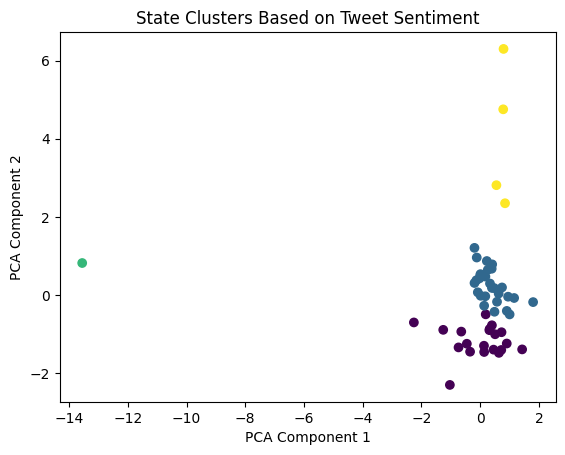

In [34]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure()
plt.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    c=state_features['cluster']
)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("State Clusters Based on Tweet Sentiment")
plt.show()


Gives a compact view of the clusters using PCA (to project onto a 2D graph). Shows 3 separate clusters being fairly close (clusters 0,1,3) and one outlier cluster (cluster 2)

### Random Forest Modeling

In [53]:
X = state_features.drop(columns=['state', 'Result', 'cluster'])
y = state_features['Result']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X_scaled, y, state_features.index, test_size=0.3, random_state=42
)

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

y_pred_proba = clf.predict_proba(X_test)
pred_df = pd.DataFrame({
    'state': state_features.loc[idx_test, 'state'],
    'voted_for': y_test,
    'pred_vote': y_pred,
    'cluster': state_features.loc[idx_test, 'cluster'],
    'Trump_prob': y_pred_proba[:, list(clf.classes_).index('Trump')],
    'Biden_prob': y_pred_proba[:, list(clf.classes_).index('Biden')]
}).reset_index(drop=True)

print(pred_df)


                   state voted_for pred_vote  cluster  Trump_prob  Biden_prob
0                  Texas     Trump     Biden        3        0.36        0.64
1         South Carolina     Trump     Trump        0        0.79        0.21
2               Virginia     Biden     Biden        1        0.23        0.77
3                  Idaho     Trump     Trump        0        0.55        0.45
4            Mississippi     Trump     Trump        0        0.75        0.25
5             New Mexico     Biden     Trump        1        0.55        0.45
6               Kentucky     Trump     Trump        0        0.75        0.25
7               New York     Biden     Biden        3        0.43        0.57
8               Arkansas     Trump     Trump        1        0.57        0.43
9             New Jersey     Biden     Biden        1        0.34        0.66
10              Illinois     Biden     Biden        1        0.39        0.61
11  District of Columbia     Biden     Trump        1        0.6

###Can you use sentiments to predict state election results?
The random forest model correctly predicted 11/16 states. It is worth noting the make up of the tweet sentiments of those states.,


1.   Connecticut - mispredicted Trump to win, while Biden has a higher average sentiment, the volume of Biden related tweens is much lower than Trump, which indicates there are more Trump tweeters, which could influence the outcome
2.   District of Colombia - mispredicted Trump to win, DC is very small so it could be difficult to predict
3.   New Mexico - mispredicted Biden to win, the actual outcome was very close, more difficult to predict based just on Twitter
4.   Texas - mispredicted Biden to win, Biden sentiment is much higher, this could be due to the disproportionate amount of Biden voters that are on Twitter
5.   Washington - mispredicted Trump to win, the volume of Biden related tweens is much lower than Trump, which indicates there are more Trump tweeters, which could influence the outcome



In [57]:
state_features[state_features['state'].isin(['Texas', 'New Mexico', 'District of Columbia', 'Connecticut', 'Washington'])]

,state,trump_avg_sent,trump_std,trump_volume,trump_pos_rate,biden_avg_sent,biden_std,biden_volume,biden_pos_rate,sentiment_gap,volume_ratio,cluster,Result
6,Connecticut,0.044096,0.268709,1141,0.296231,0.073383,0.305202,878,0.339408,-0.029286,1.298066,0,Biden
8,District of Columbia,0.047494,0.259472,9684,0.336121,0.089075,0.253852,7055,0.364989,-0.041581,1.372449,1,Biden
32,New Mexico,0.043375,0.271506,502,0.332669,0.111062,0.295294,446,0.392377,-0.067687,1.123043,1,Biden
45,Texas,0.043140,0.280440,16491,0.337942,0.076986,0.289218,14191,0.373617,-0.033847,1.161993,3,Trump
49,Washington,0.075899,0.307224,2759,0.395071,0.078186,0.283883,2112,0.381155,-0.002286,1.305726,1,Biden


### Setiment Analysis

<Axes: >

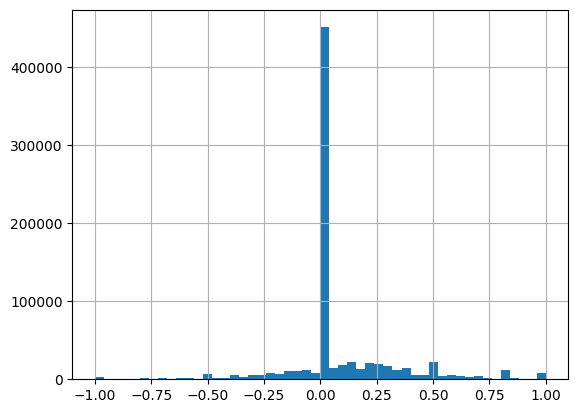

In [ ]:
df_biden['sentiment'].hist(bins=50)

<Axes: >

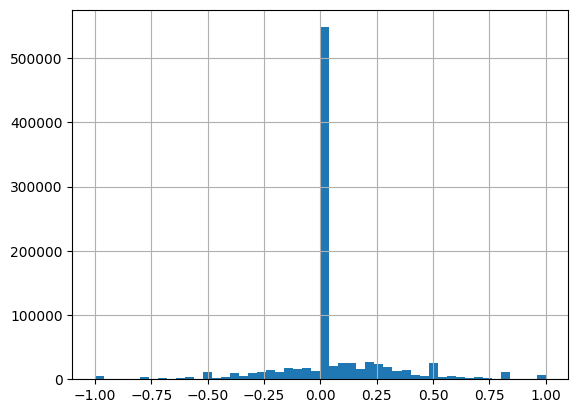

In [ ]:
df_trump['sentiment'].hist(bins=50)


Sentiment thresholds of ±0.2 were used to isolate clearly positive and negative tweets, reducing noise from weak or ambiguous sentiment. The following is a visualization of where Biden and Trump tweets lie.


In [35]:
# categorizes tweets as positive, negative, and neutral based on threshold and sentiment previously calculated
def split_by_sentiment(df, text_col='tweet', sent_col='sentiment', pos_thresh=0.2, neg_thresh=-0.2):
    positive = df[df[sent_col] > pos_thresh][text_col]
    negative = df[df[sent_col] < neg_thresh][text_col]
    neutral  = df[(df[sent_col] >= neg_thresh) & (df[sent_col] <= pos_thresh)][text_col]
    return positive, negative, neutral
trump_pos, trump_neg, trump_neu = split_by_sentiment(df_trump)
biden_pos, biden_neg, biden_neu = split_by_sentiment(df_biden)


In [36]:
# cleans text by removing URLs, mentions, and punctuation, and keeps hashtag words
def clean_for_analysis(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"#", "", text)
    text = re.sub(r"[^a-z\s]", "", text)
    return text
trump_pos_clean = trump_pos.apply(clean_for_analysis)
biden_pos_clean = biden_pos.apply(clean_for_analysis)
trump_neg_clean = trump_neg.apply(clean_for_analysis)
biden_neg_clean = biden_neg.apply(clean_for_analysis)

In [39]:
# finds the 20 most common words in negative Trump and Biden tweets
print("Biden Common Words: \n", Counter(" ".join(trump_neg_clean).split()).most_common(20))
print("Trump Common Words: \n", Counter(" ".join(biden_neg_clean).split()).most_common(20))

Biden Common Words: 
 [('trump', 84761), ('the', 64669), ('to', 41194), ('is', 37231), ('a', 34240), ('and', 32691), ('of', 29602), ('in', 22095), ('for', 19534), ('you', 18403), ('he', 15720), ('this', 15206), ('that', 14720), ('biden', 14280), ('are', 13505), ('i', 12604), ('his', 11889), ('it', 11523), ('on', 11386), ('not', 10585)]
Trump Common Words: 
 [('biden', 35081), ('the', 34112), ('to', 23169), ('is', 20666), ('trump', 19070), ('a', 18457), ('and', 18323), ('joebiden', 17600), ('of', 14347), ('for', 12826), ('in', 11761), ('you', 11174), ('this', 8472), ('that', 8454), ('i', 7610), ('are', 7051), ('election', 6941), ('he', 6789), ('vote', 6748), ('it', 6590)]


## Observations
Trump is the most common word in tweets about Biden, This suggests that Biden-related discourse is often framed in opposition to Trump rather than independently.

Similarly, Biden is appears more often than Trump in Trump related tweets. Which also indicates that many tweets are comparitive between the candidates

In [40]:
# Fits and LDA model to get Sentiment Related topics for both candidates
vectorizer = TfidfVectorizer(
    stop_words="english",
    max_df=0.95,
    min_df=20,
    ngram_range=(1, 2)
)

tfidf_pos_trump = vectorizer.fit_transform(trump_pos_clean)
tfidf_neg_trump = vectorizer.fit_transform(trump_neg_clean)


tfidf_pos_biden = vectorizer.fit_transform(biden_pos_clean)
tfidf_neg_biden = vectorizer.fit_transform(biden_neg_clean)

In [41]:
lda_pos_trump = LatentDirichletAllocation(n_components=5, random_state=42)
lda_neg_trump = LatentDirichletAllocation(n_components=5, random_state=42)

lda_pos_biden = LatentDirichletAllocation(n_components=5, random_state=42)
lda_neg_biden = LatentDirichletAllocation(n_components=5, random_state=42)

lda_pos_trump.fit(tfidf_pos_trump)
lda_neg_trump.fit(tfidf_neg_trump)

lda_pos_biden.fit(tfidf_pos_biden)
lda_neg_biden.fit(tfidf_neg_biden)


LatentDirichletAllocation(n_components=5, random_state=42)

In [42]:
def display_topics(model, feature_names, n_top_words=10):
    n_features = len(feature_names)

    for topic_idx, topic in enumerate(model.components_):
        # Clip indices to valid range (safety guard)
        valid_indices = topic.argsort()[::-1]
        valid_indices = valid_indices[valid_indices < n_features]

        top_indices = valid_indices[:n_top_words]
        top_words = [feature_names[i] for i in top_indices]

        print(f"Topic {topic_idx + 1}: {', '.join(top_words)}\n")


In [43]:
print("Positive Trump Sentiment Topics")
display_topics(lda_pos_trump, vectorizer.get_feature_names_out())

print("Negative Trump Sentiment Topics")
display_topics(lda_neg_trump, vectorizer.get_feature_names_out())

print("Positive Biden Sentiment Topics")
display_topics(lda_pos_biden, vectorizer.get_feature_names_out())

print("Negative Biden Sentiment Topics")
display_topics(lda_neg_biden, vectorizer.get_feature_names_out())


Positive Trump Sentiment Topics
Topic 1: begin, declares, means, bible, terrorist, saying, turntexasblue, bullshit, competition, vote blue

Topic 2: declares, terrorist, trump trump, saying, trump big, dj, door, trump fake, trump loses, selling

Topic 3: saying, means, declares, biden makes, dans les, single, ruined, criminal enterprise, pure, riots

Topic 4: biden makes, declares, saying, terrorist, single, means, begin, dans les, criminal enterprise, im sick

Topic 5: terrorist, declares, saying, saveamerica, begin, criminal enterprise, saving, trump trump, trump loses, biden makes

Negative Trump Sentiment Topics
Topic 1: maga maga, respect, president history, den, biden sucks, sucks, election election, amp, responds, help joebiden

Topic 2: trump fuck, election election, blind, help joebiden, anymore, leaked, fascists, monopoly, dramatic, quidproquo trump

Topic 3: iphone samsung, blind, help joebiden, authority, travel, moderator, share bibleprohecy, horrific, terror, people stupi

## Topic Modeling Insights

Topic modeling reveals that Twitter discourse surrounding both candidates is highly event-driven and personality-focused, with limited emphasis on policy discussion.

### Trump Sentiment

#### Positive Trump Sentiment
Positive Trump tweets often uses slogans and hashtags (saveamerica, turntexasblue, vote blue). They also tend to include mention of the opposite side, as seen in the slogans and hashtags. There also tends to be a lot of emotion heavy language such as imsick and terrorist.

#### Negative Trump Sentiment
Negative Trump sentiment is frequently characterized by profanity, election controversy, and direct attacks (maga, people stupid, fascists). They also mention election legitimacy and controversy (election election, wisconsin florida) and mention Joe Biden often (help joebiden, biden sucks).

### Biden Sentiment

#### Positive Biden Sentiment
Positive Biden sentiment emphasizes election outcomes and group alliance/identity (americafirst, blacktwitter, bidenharris). They also heavily mention election outcomes and legitimacy (congratulations joebiden, electionnight)

#### Negative Trump Sentiment
Negative Biden sentiment focuses heavily on personal scandals and corruption narratives (hunterbiden, bidencorrupt).

### Cross-Candidate Comparison
Overall, Trump related discourse appears more confrontational and emotionally charged, whereas Biden related discourse is more outcome-oriented, but also uses strong language when discussing the opposition.


## Limitations

- Twitter users are not representative of the general population
- Sentiment models may misinterpret sarcasm
- Dataset may be biased toward English-language tweets
- Topic terms reflect the noisy and informal nature of social media language. Topics represent clusters of words rather than coherent opinions and cannot be considered be definitive viewpoints. but rather thematic patterns.